In [15]:
import yaml
import gym
from gym import spaces
import numpy as np
import pandas as pd
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from collections import deque
from tqdm import tqdm
from datetime import datetime

from stock_data import get_hs300_sample, get_stock_data, get_stock_name
import backtrader as bt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

config = yaml.safe_load(open("config.yaml"))
initial_cash = config['user']['initial_cash']

# 设定PyTorch使用的设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 获取数据
amount = 1
start_date = '20211115'
end_date = '20241115'
# data = get_hs300_sample(stock_count=1, start_date=start_date, end_date=end_date)
# test_data = data[list(data.keys())[0]] # 取出第一只股票的数据
id = config['stock_list'][0]['id']
name = get_stock_name(id)
print(f'{id} {name}')
test_data = get_stock_data(id, start_date=start_date, end_date=end_date)

# 计算出区间涨幅作为起始的收益率基准
start_price = test_data['close'].iloc[0]
end_price = test_data['close'].iloc[-1]
base_return = (end_price - start_price) / start_price
print(f'区间涨幅: {base_return:.2%}')

print(test_data.head())

601857 中国石油
区间涨幅: 66.94%
            open  close  high   low   volume  turnover
datetime                                              
2021-11-15  4.80   4.81  4.83  4.76  1231063      0.08
2021-11-16  4.81   4.77  4.85  4.77  1725119      0.11
2021-11-17  4.77   4.83  4.83  4.74  1275661      0.08
2021-11-18  4.78   4.77  4.81  4.76  1368661      0.08
2021-11-19  4.77   4.83  4.85  4.74  1502051      0.09


In [43]:
# 设定PyTorch使用的设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class StockTradingEnv(gym.Env):
    def __init__(self, data):
        super(StockTradingEnv, self).__init__()

        self.data = data
        self.current_step = 0
        self.done = False

        # 动作空间：0 - 持有，1 - 买入，2 - 卖出
        self.action_space = spaces.Discrete(3)

        # 状态空间：当前持有股票数量、当前现金余额、当前股票价格、买入比例、卖出比例、移动平均线、RSI等
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(7,), dtype=np.float32)

        # 初始状态
        self.initial_balance = initial_cash
        self.transaction_fee_rate = 0.0005  # 手续费万分之五
        self.reset()

        # 用于记录每日数据
        self.history = []
        self.daily_operations = []  # 每日操作日志

        # 技术指标参数
        self.window_size = 14  # RSI窗口大小
        self.prices = []  # 存储历史价格用于计算指标

    def reset(self):
        self.current_step = 0
        self.done = False
        self.current_balance = self.initial_balance
        self.current_stock_owned = 0
        self.current_stock_price = self.data[self.current_step]['close']

        self.history = []  # 清空历史记录
        self.daily_operations = []  # 清空每日操作日志
        self.prices = []  # 清空价格历史

        # 随机生成买入和卖出比例
        self.buy_ratio = 0.5
        self.sell_ratio = 0.5

        return torch.tensor([self.current_stock_owned, self.current_balance, self.current_stock_price, self.buy_ratio, self.sell_ratio, 0, 0], dtype=torch.float32, device=device)
    
    def calculate_reward(self, current_balance, previous_balance, trade_flag):
        rate_of_return = (current_balance - previous_balance) / previous_balance
        reward = rate_of_return
        # 频繁交易奖励
        if trade_flag:
            reward += 0.1
        # 如果为负数，惩罚增加
        if reward < 0:
            reward *= 2
        return reward
    
    def calculate_indicators(self):
        # 计算简单移动平均线和相对强弱指数（RSI）
        if len(self.prices) >= 2:
            sma = np.mean(self.prices[-2:])  # 最近两个价格的简单移动平均
        else:
            sma = 0

        if len(self.prices) >= self.window_size:
            delta = np.diff(self.prices[-self.window_size:], n=1)
            gain = np.mean(delta[delta > 0]) if np.any(delta > 0) else 0
            loss = -np.mean(delta[delta < 0]) if np.any(delta < 0) else 0
            rs = gain / loss if loss != 0 else 0
            rsi = 100 - (100 / (1 + rs))
        else:
            rsi = 0

        return sma, rsi

    # 在环境类中
    def step(self, action):
        buy_today = False  # 今天是否买入
        sell_today = False
        previous_balance = self.current_balance
        self.prices.append(self.current_stock_price)  # 记录当前价格用于计算指标
        sma, rsi = self.calculate_indicators()  # 计算指标

        # 执行动作
        if action == 1:  # 买入
            max_buy_amount = int(self.current_balance // self.current_stock_price)
            buy_amount = int(max_buy_amount * self.buy_ratio)
            # 买入只能是1手（100股）的整数倍
            buy_amount = buy_amount - buy_amount % 100

            if buy_amount > 0:
                buy_today = True # 今天买入
                # 计算手续费
                fee = buy_amount * self.current_stock_price * self.transaction_fee_rate
                self.current_stock_owned += buy_amount
                self.current_balance -= buy_amount * self.current_stock_price + fee
                # 记录每日买入操作
                self.daily_operations.append({
                    'time': self.data[self.current_step]['date'].strftime('%Y-%m-%d'),
                    'action': 'buy',
                    'price': self.current_stock_price,
                    'amount': buy_amount,
                    'fee': fee,
                    'cash': self.current_balance,
                    'total_value': self.current_balance + self.current_stock_owned * self.current_stock_price,
                    'sma': sma,  # 添加简单移动平均线
                    'rsi': rsi,
                    'stock_owned': self.current_stock_owned, # 添加持有股票数量
                    'stock_value': self.current_stock_owned * self.current_stock_price # 添加持有股票市值
                })

        elif action == 2:  # 卖出
            max_sell_amount = self.current_stock_owned
            sell_amount = int(max_sell_amount * self.sell_ratio)
            # 卖出只能是1手（100股）的整数倍
            sell_amount = sell_amount - sell_amount % 100

            if sell_amount > 0:
                # 今天卖出
                sell_today = True
                # 计算手续费
                fee = sell_amount * self.current_stock_price * self.transaction_fee_rate
                self.current_stock_owned -= sell_amount
                self.current_balance += sell_amount * self.current_stock_price - fee
                # 记录每日卖出操作
                self.daily_operations.append({
                    'time': self.data[self.current_step]['date'].strftime('%Y-%m-%d'),
                    'action': 'sell',
                    'price': self.current_stock_price,
                    'amount': sell_amount,
                    'fee': fee,
                    'cash': self.current_balance,
                    'total_value': self.current_balance + self.current_stock_owned * self.current_stock_price,
                    'sma': sma,  # 添加简单移动平均线
                    'rsi': rsi,
                    'stock_owned': self.current_stock_owned, # 添加持有股票数量
                    'stock_value': self.current_stock_owned * self.current_stock_price # 添加持有股票市值
                })
        else: # 持有
            self.daily_operations.append({
                'time': self.data[self.current_step]['date'].strftime('%Y-%m-%d'),
                'action': 'hold',
                'price': self.current_stock_price,
                'amount': 0,
                'fee': 0,
                'cash': self.current_balance,
                'total_value': self.current_balance + self.current_stock_owned * self.current_stock_price,
                'sma': sma,  # 添加简单移动平均线
                'rsi': rsi,  # 添加RSI
                'stock_owned': self.current_stock_owned, # 添加持有股票数量
                'stock_value': self.current_stock_owned * self.current_stock_price # 添加持有股票市值
            })

        # 更新股票价格
        self.current_step += 1
        if self.current_step < len(self.data):
            self.current_stock_price = self.data[self.current_step]['close']
        else:
            self.done = True  # 数据结束，标记为完成
            
        # 定义是否交易的标志
        trade_flag = buy_today or sell_today

        # 计算奖励
        reward = self.calculate_reward(self.current_balance, previous_balance,trade_flag)

        # 记录每日数据
        total_value = self.current_balance + self.current_stock_owned * self.current_stock_price
        self.history.append({
            'total_value': total_value,
            'cash': self.current_balance,
            'stock_value': self.current_stock_owned * self.current_stock_price,
            'step': self.current_step,
            'time': self.data[self.current_step]['date'] if self.current_step < len(self.data) else None,  # 添加时间
            'buy_ratio': self.buy_ratio,  # 买入比例
            'sell_ratio': self.sell_ratio,  # 卖出比例
            'sma': sma,  # 添加简单移动平均线
            'rsi': rsi  # 添加RSI
        })
        

        # 返回状态、奖励、是否结束、额外信息
        state = torch.tensor([self.current_stock_owned, self.current_balance, self.current_stock_price, self.buy_ratio, self.sell_ratio, sma, rsi], dtype=torch.float32).to(device)
        return state, reward, self.done, {}



    def render(self, mode='human'):
        pass  # 不输出每一步的操作

epsilon_max_global = 0.5  # 全局最大探索率
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # 经验回放缓冲区
        self.gamma = 0.99  # 折扣因子
        self.epsilon = epsilon_max_global  # 探索率
        self.epsilon_min = 0.01  # 最小探索率
        self.epsilon_decay = 0.995  # 探索率衰减
        self.learning_rate = 0.0005  # 学习率
        self.model = self._build_model()  # 创建神经网络模型
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)  # 定义优化器
        self.criterion = nn.MSELoss()  # 定义损失函数
        
        self.buy_today = False  # 今天是否买入
        self.sell_today = False  # 今天是否卖出

    def _build_model(self):
        class QNetwork(nn.Module):
            def __init__(self, state_size, action_size, dropout_rate=0.2):
                super(QNetwork, self).__init__()
                # 定义隐藏层
                self.fc1 = nn.Linear(state_size, 128)  
                self.fc2 = nn.Linear(128, 256)
                #self.gru = nn.GRU(256, 256, 2, batch_first=True, dropout=dropout_rate)
                self.fc3 = nn.Linear(256, action_size)
                self.dropout = nn.Dropout(dropout_rate)
                
            def forward(self, x):
                x = F.relu(self.fc1(x))
                x = F.relu(self.fc2(x))
                x = self.dropout(x)
                # x, _ = self.gru(x.unsqueeze(0))
                
                x = self.fc3(x)
                return x
            
        model = QNetwork(self.state_size, self.action_size).to(device)
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = state.clone().detach().requires_grad_(True).to(device)
            next_state = next_state.clone().detach().requires_grad_(True).to(device)

            target = reward
            if not done:
                # 使用双重DQN
                target += self.gamma * torch.max(self.model(next_state).detach())

            target_f = self.model(state).detach().cpu().numpy().squeeze()
            if len(target_f.shape) == 1:  
                target_f = target_f.reshape(1, -1)
            target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(state), torch.FloatTensor(target_f).to(device))
            loss.backward()
            self.optimizer.step()
            
    # 定义保存和加载模型的方法
    def save_model(self, episode):
        torch.save(self.model.state_dict(), f'dqn_model_{episode}.pth')

    def load_model(self, episode):
        self.model.load_state_dict(torch.load(f'dqn_model_{episode}.pth', weights_only=True))


def train_agent(env, agent, episodes=1000, batch_size=32, start_episode=0):
    previous_profit = 0
    min_profit = 10
    max_profit = 0
    all_daily_operations = []  # 存储所有 daily_operations
    initial_profit = base_return*100 # 用区间涨幅作为初始目标收益率
    target_profit = initial_profit  # 目标收益率

    for e in range(episodes):
        state = env.reset()
        state = state.clone().detach().requires_grad_(True).to(device)
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = next_state.clone().detach().requires_grad_(True).to(device)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            
        # 每次训练结束后记录 daily_operations
        all_daily_operations.append(env.daily_operations.copy())
        
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        
        # 更新探索率和目标收益率
        profit = calculate_profit(all_daily_operations[-1])

        # 1. 动态调整目标收益率和探索率
        if profit > target_profit:
            # 如果收益率超过目标收益率，提高目标收益率
            target_profit = min(profit, target_profit + 1)  # 提高目标收益率 1%
            print(f"[REWARD] 第{e + 1 + start_episode}次训练，收益率{profit:.2f}%超过了目标收益率: {target_profit:.2f}%", f"目标收益率提高到: {target_profit:.2f}%", f"当前最高收益率: {max_profit:.2f}%")
            agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)  # 衰减探索率
            # 如果收益率超过最大收益率，更新最大收益率，并且超过目标收益率0.5%以上，奖励探索率衰减
            if profit > max_profit:
                # 如果max_profit为0
                if max_profit == 0:
                    if profit > 0:
                        max_profit = profit
                        print(f"[INIT] 第{e + 1 + start_episode}次训练，初始化最大收益率为: {max_profit:.2f}%")
                else:
                    over_profit = profit - target_profit
                    over_profit_rate = over_profit / target_profit
                    reward_num = over_profit_rate // 0.4
                    decay_rate = 0.99 ** reward_num * agent.epsilon_decay
                    agent.epsilon = max(agent.epsilon * decay_rate, agent.epsilon_min)
                    max_profit = profit
                    print(f"[REWARD] 第{e + 1 + start_episode}次训练，收益率{profit:.2f}%超过了历史最高收益率！探索率衰减比率: {decay_rate:.4f}", f"当前最高收益率: {max_profit:.2f}%")
                
        elif profit < min_profit:
            # 如果收益率为负数，降低目标收益率
            target_profit = max(initial_profit, target_profit - 0.1)  # 降低目标收益率 0.1%
            min_profit = profit
            print(f"[MIN] 第{e + 1 + start_episode}次训练，最低收益率降低到: {min_profit:.2f}%", f"目标收益率降低到: {target_profit:.2f}%", f"当前最低收益率: {min_profit:.2f}%")
            # 略微增加探索率
            agent.epsilon = min(agent.epsilon * 1.01, epsilon_max_global)  # 增加探索率
        
        # 如果收益为正数，减少探索率
        if profit > 0:
            agent.epsilon = max(agent.epsilon * 0.9995, agent.epsilon_min)  # 衰减探索率
        # 如果收益率为负数，增加探索率
        if profit < 0:
            agent.epsilon = min(agent.epsilon * 1.0001, epsilon_max_global)  # 增加探索率
            
        # 记录上次收益率
        previous_profit = profit

        # 保存模型的训练效果数据到csv文件
        profit = calculate_profit(all_daily_operations[-1])
        with open("training_results.csv", "a") as f:
            f.write(f"{e + 1 + start_episode},{profit},{agent.epsilon}\n")

        # 每100次保存一次模型
        if (e + 1 + start_episode) % 100 == 0:
            agent.save_model(e + 1 + start_episode)
    
    return all_daily_operations
        
def print_daily_operations(operations):
    for op in operations:
        # 输出每日操作日志
        date = op['time']
        stock_value = op['amount'] * op['price']
        total_value = op['total_value']
        fee = op['fee']
        amount = op['amount']
        action = op['action']
        percentage = (stock_value / initial_cash) * 100
        # 输出 对齐
        if action == 'buy':
            print(f"日期: {date}, 买入: {amount}股, 价格: {op['price']:.2f}, 费用: {fee:.2f}, 持仓市值: {stock_value:.2f}, 总市值: {total_value:.2f}, 占比: {percentage:.2f}%")
        elif action == 'sell':
            print(f"日期: {date}, 卖出: {amount}股, 价格: {op['price']:.2f}, 费用: {fee:.2f}, 持仓市值: {stock_value:.2f}, 总市值: {total_value:.2f}, 占比: {percentage:.2f}%")
        else:
            print(f"日期: {date}, 无操作")

def calculate_profit(operations):
    # 计算总资产变化的收益率
    if not operations:
        return 0
    initial_value = initial_cash
    final_value = operations[-1]['total_value']  # 最后一次操作的总资产
    return (final_value - initial_value) / initial_value * 100  # 计算收益率（百分比）

if __name__ == "__main__":
    df = test_data.copy()
    df.reset_index(inplace=True)
    df['date'] = pd.to_datetime(df['datetime'])

    # 询问是否继续训练
    start_episode = 0
    load_episode = input("请输入要加载的训练次数（若不加载，请直接回车）：")
    if load_episode:
        start_episode = int(load_episode)

    env = StockTradingEnv(df.to_dict(orient='records'))
    
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    # 如果加载训练次数，则加载模型
    if start_episode > 0:
        agent.load_model(start_episode)

    # 训练智能体 并且返回每日操作日志
    episodes = 500 # 训练
    all_daily_operations = train_agent(env, agent, episodes=episodes, batch_size=64, start_episode=start_episode)
    

c:\Users\Pejoy\anaconda3\envs\stock\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[REWARD] 第3509次训练，收益率67.38%超过了目标收益率: 67.38% 目标收益率提高到: 67.38% 当前最高收益率: 0.00%
[INIT] 第3509次训练，初始化最大收益率为: 67.38%
[MIN] 第3510次训练，最低收益率降低到: 7.63% 目标收益率降低到: 67.28% 当前最低收益率: 7.63%
[MIN] 第3514次训练，最低收益率降低到: 2.70% 目标收益率降低到: 67.18% 当前最低收益率: 2.70%
[MIN] 第3520次训练，最低收益率降低到: -2.09% 目标收益率降低到: 67.08% 当前最低收益率: -2.09%
[REWARD] 第3525次训练，收益率75.82%超过了目标收益率: 68.08% 目标收益率提高到: 68.08% 当前最高收益率: 67.38%
[REWARD] 第3525次训练，收益率75.82%超过了历史最高收益率！探索率衰减比率: 0.9950 当前最高收益率: 75.82%
[REWARD] 第3540次训练，收益率82.09%超过了目标收益率: 69.08% 目标收益率提高到: 69.08% 当前最高收益率: 75.82%
[REWARD] 第3540次训练，收益率82.09%超过了历史最高收益率！探索率衰减比率: 0.9950 当前最高收益率: 82.09%
[REWARD] 第3551次训练，收益率72.19%超过了目标收益率: 70.08% 目标收益率提高到: 70.08% 当前最高收益率: 82.09%
[MIN] 第3554次训练，最低收益率降低到: -2.68% 目标收益率降低到: 69.98% 当前最低收益率: -2.68%
[MIN] 第3610次训练，最低收益率降低到: -10.28% 目标收益率降低到: 69.88% 当前最低收益率: -10.28%
[MIN] 第3613次训练，最低收益率降低到: -14.51% 目标收益率降低到: 69.78% 当前最低收益率: -14.51%
[REWARD] 第3618次训练，收益率70.39%超过了目标收益率: 70.39% 目标收益率提高到: 70.39% 当前最高收益率: 82.09%
[REWARD] 第3669次训练，收益率93.40%超过了目标收益率: 71.39% 目标收益率提高到

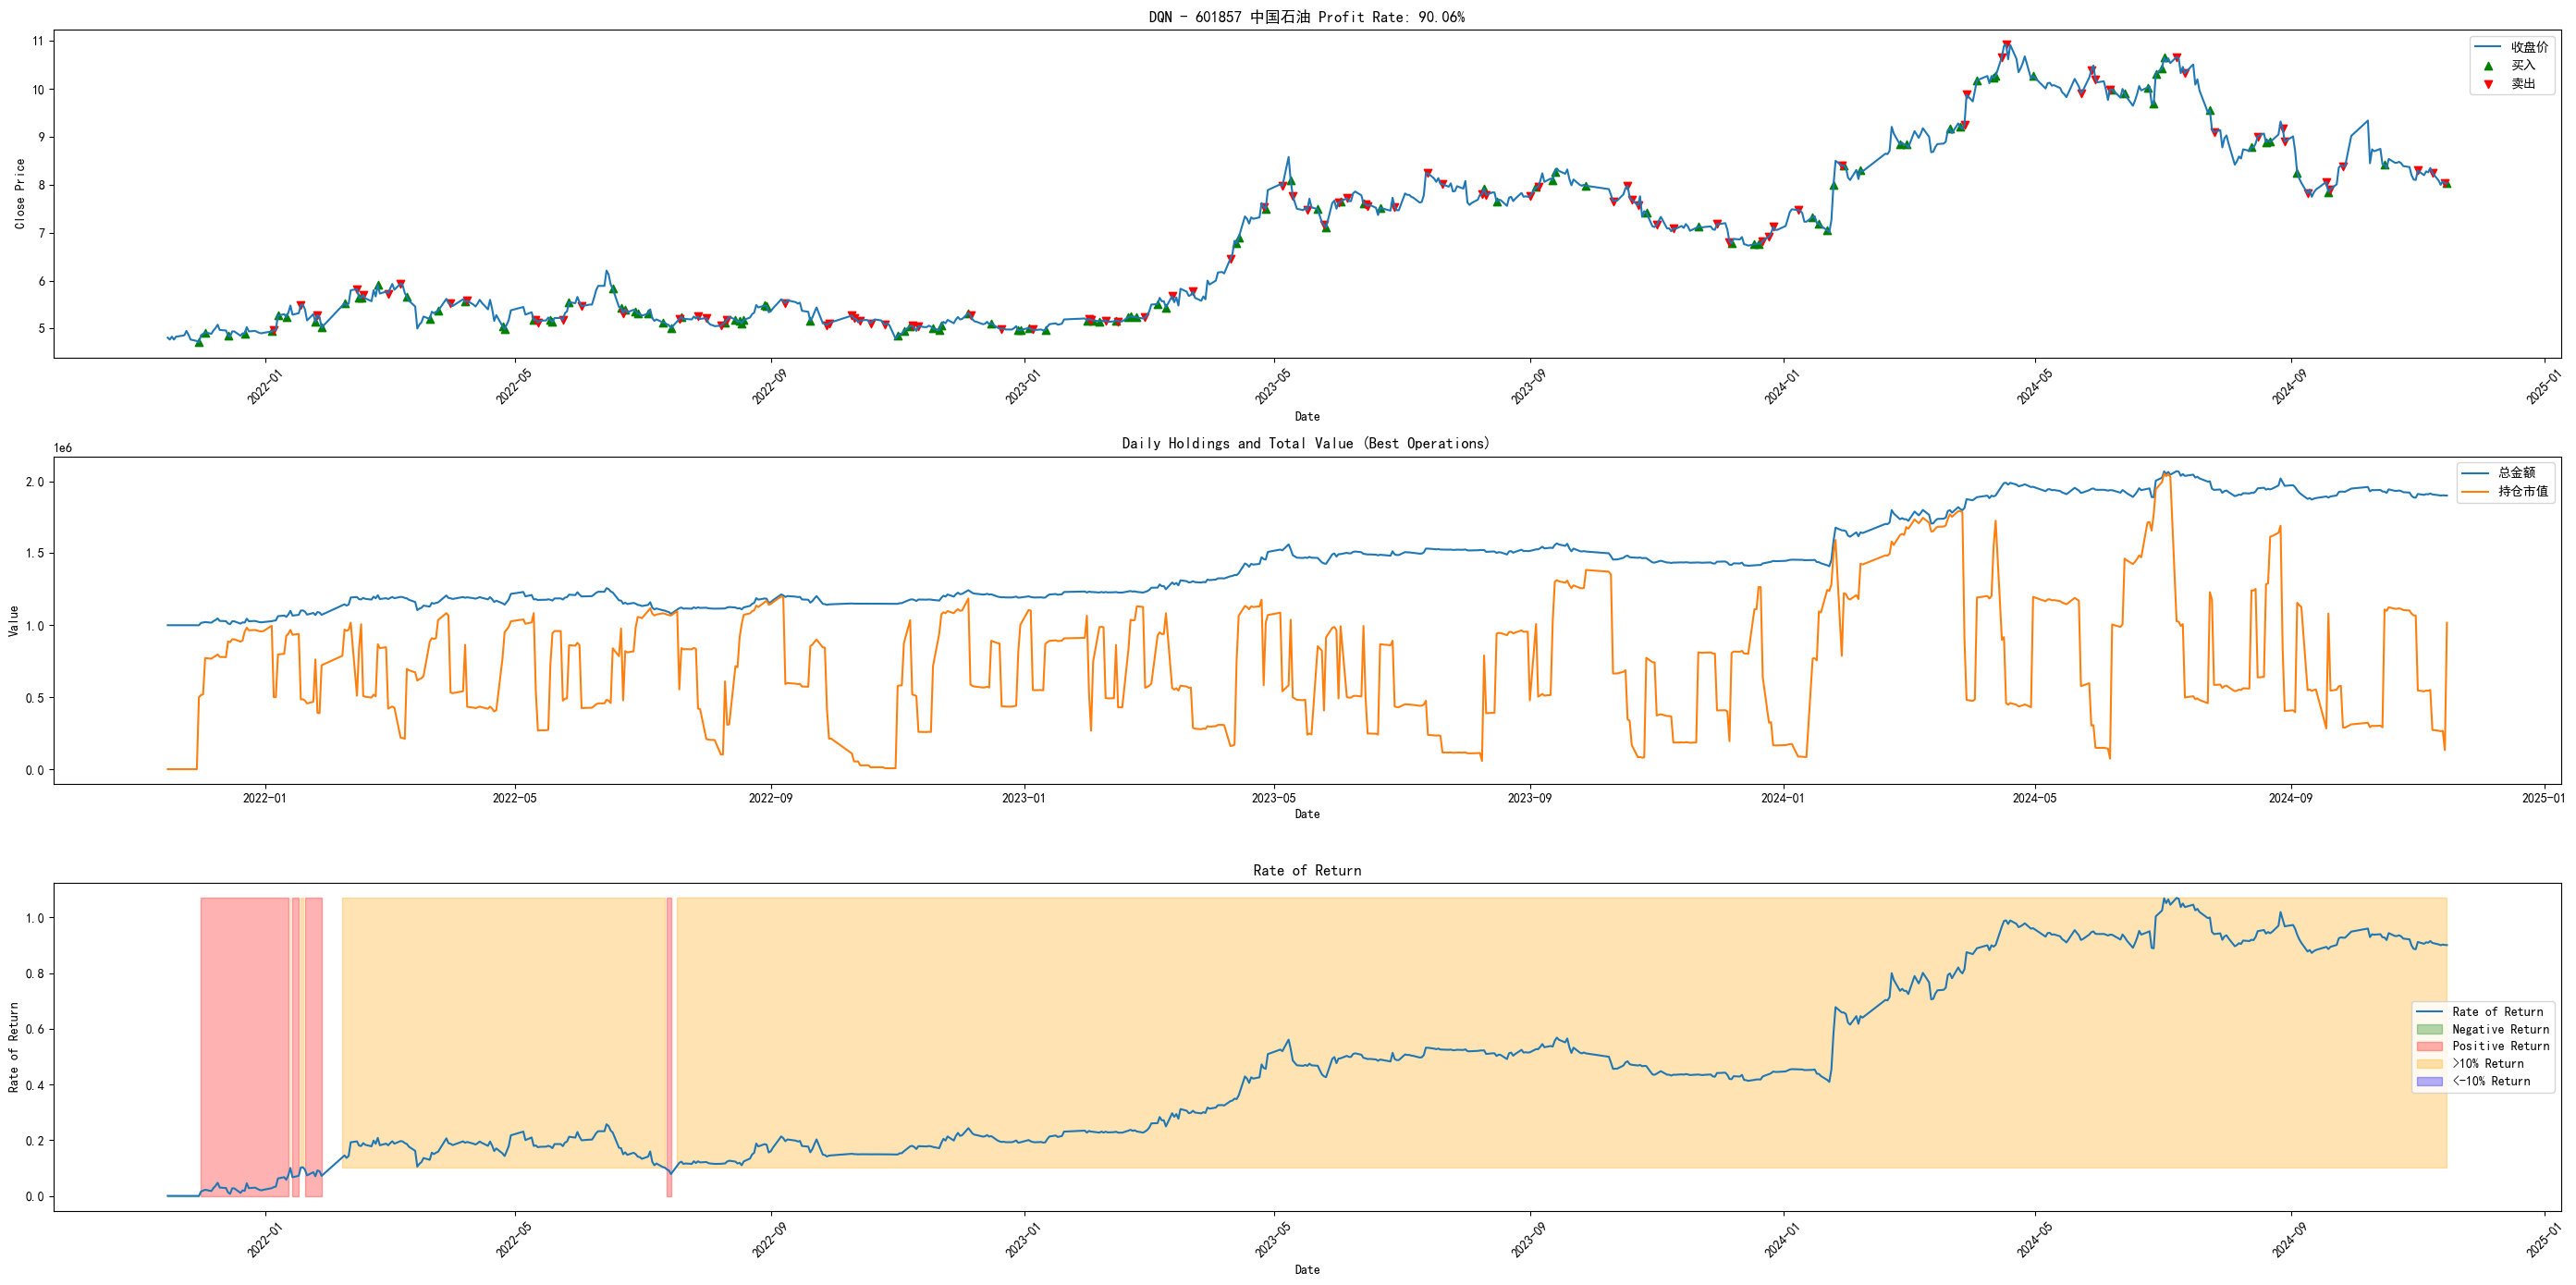

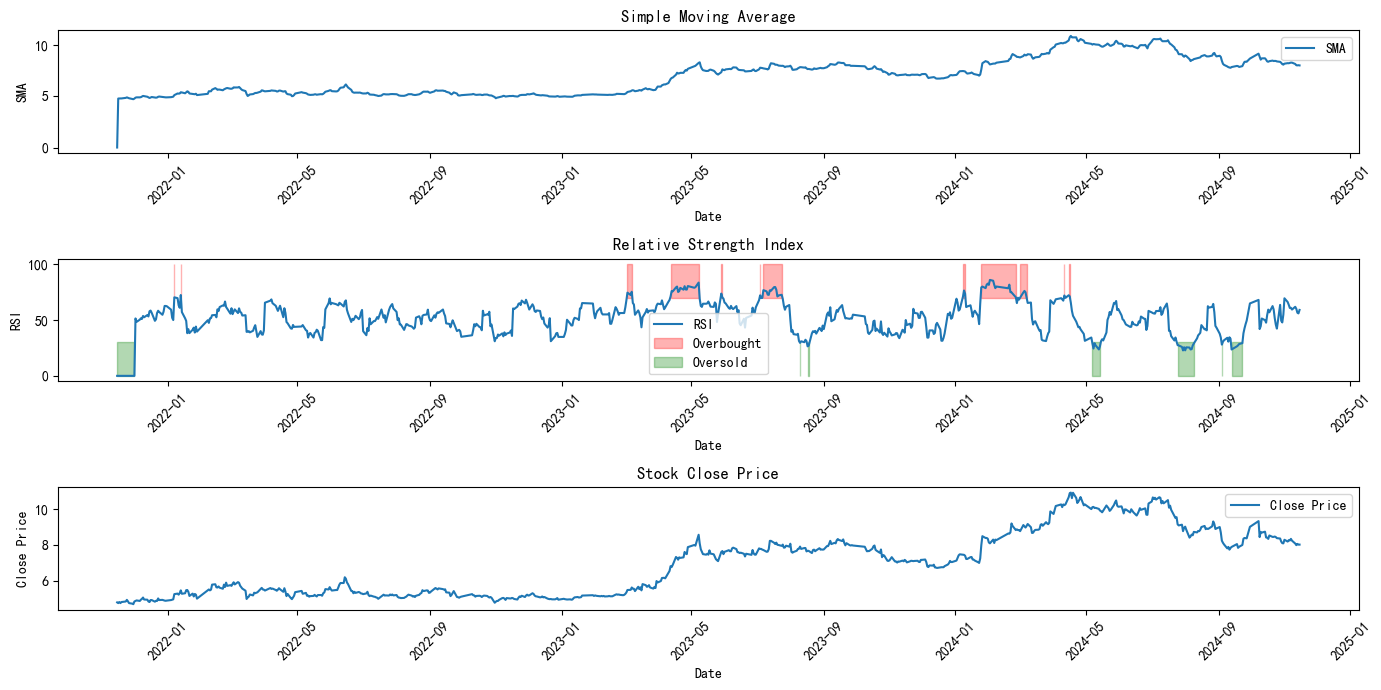

In [42]:
best_operations = max(all_daily_operations, key=lambda x: calculate_profit(x))
import matplotlib.dates as mdates

# 输出最佳利率
operation_df = pd.DataFrame(best_operations)
operation_df['time'] = pd.to_datetime(operation_df['time'])
profit_rate = calculate_profit(best_operations)

# 画图
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
plt.figure(figsize=(28, 14))

# 子图1: 股票收盘价和买卖信号
plt.subplot(3, 1, 1)
plt.plot(df['date'], df['close'], label='收盘价')
plt.scatter(operation_df[operation_df['action'] == 'buy']['time'], operation_df[operation_df['action'] == 'buy']['price'], marker='^', c='g', label='买入')
plt.scatter(operation_df[operation_df['action'] == 'sell']['time'], operation_df[operation_df['action'] == 'sell']['price'], marker='v', c='r', label='卖出')
plt.title(f'DQN - {id} {name} Profit Rate: {profit_rate:.2f}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# 设置日期格式为按月显示
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自动选择合适的日期间隔
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 按 "年-月" 格式显示日期
plt.xticks(rotation=45)  # 旋转日期标签，避免重叠

# 子图2: 每日的持仓和总金额
plt.subplot(3, 1, 2)
operation_df['total_value'] = operation_df['cash'] + operation_df['stock_value']
plt.plot(operation_df['time'], operation_df['total_value'], label='总金额')
plt.plot(operation_df['time'], operation_df['stock_value'], label='持仓市值')
plt.title('Daily Holdings and Total Value (Best Operations)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# 收益率曲线 低于0的部分标记为绿色 高于0的部分标记为红色 低于10%的部分标记为蓝色 高于10%的部分标记为橙色
plt.subplot(3, 1, 3)
operation_df['rate_of_return'] = (operation_df['total_value'] - initial_cash) / initial_cash
plt.plot(operation_df['time'], operation_df['rate_of_return'], label='Rate of Return')
# 首先找到上界和下界 作为图标的纵轴
upper_bound = operation_df['rate_of_return'].max()
lower_bound = operation_df['rate_of_return'].min()
plt.fill_between(operation_df['time'], lower_bound, 0, where=(operation_df['rate_of_return'] <= 0), color='green', alpha=0.3, label='Negative Return')
plt.fill_between(operation_df['time'], 0, upper_bound, where=(operation_df['rate_of_return'] > 0) & (operation_df['rate_of_return'] < 0.1), color='red', alpha=0.3, label='Positive Return')
plt.fill_between(operation_df['time'], 0.1, upper_bound, where=(operation_df['rate_of_return'] >= 0.1), color='orange', alpha=0.3, label='>10% Return')
plt.fill_between(operation_df['time'], lower_bound, -0.1, where=(operation_df['rate_of_return'] <= -0.1), color='blue', alpha=0.3, label='<-10% Return')
plt.title('Rate of Return')
plt.xlabel('Date')
plt.ylabel('Rate of Return')
plt.legend()

# 设置日期格式为按月显示
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 子图3: RSI和移动平均线
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(operation_df['time'], operation_df['sma'], label='SMA')
plt.title('Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('SMA')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
plt.plot(operation_df['time'], operation_df['rsi'], label='RSI')
plt.fill_between(operation_df['time'], 70, 100, where=(operation_df['rsi'] >= 70), color='red', alpha=0.3, label='Overbought')
plt.fill_between(operation_df['time'], 0, 30, where=(operation_df['rsi'] <= 30), color='green', alpha=0.3, label='Oversold')
plt.title('Relative Strength Index')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
plt.plot(df['date'], df['close'], label='Close Price')
plt.title('Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [25]:
# 算出收益率 夏普比率 最大回撤
# 在best_operations提取出每日的总资产
total_values = [op['total_value'] for op in best_operations]
total_values = np.array(total_values)

def max_drawdown(arr):
    # 计算最大回撤率
    peek = 0
    drawdown = 0
    for i in range(1, len(arr)):
        if arr[i] > arr[peek]:
            peek = i
        else:
            dd = (arr[peek] - arr[i]) / arr[peek]
            drawdown = max(drawdown, dd)
    return drawdown

def sharpe_ratio(arr):
    # 计算夏普比率
    returns = np.diff(arr) / arr[:-1]
    return (np.mean(returns) * 252 - 0.01) / (np.std(returns) * np.sqrt(252))

profit_rate = calculate_profit(best_operations)
max_drawdown_rate = max_drawdown(total_values)
sharpe = sharpe_ratio(total_values)
print(f"收益率: {profit_rate:.2f}%")
print(f"最大回撤率: {max_drawdown_rate*100:.2f}%")
print(f"夏普比率: {sharpe:.4f}")

# 添加到结果文件
with open(f'{id}.csv', 'a') as f:
    # 策略名称, 收益率, 最大回撤率, 夏普比率
    f.write(f'DQN, {profit_rate:.2f}, {max_drawdown_rate*100:.2f}, {sharpe:.4f}\n')

收益率: 114.19%
最大回撤率: 16.88%
夏普比率: 1.3229


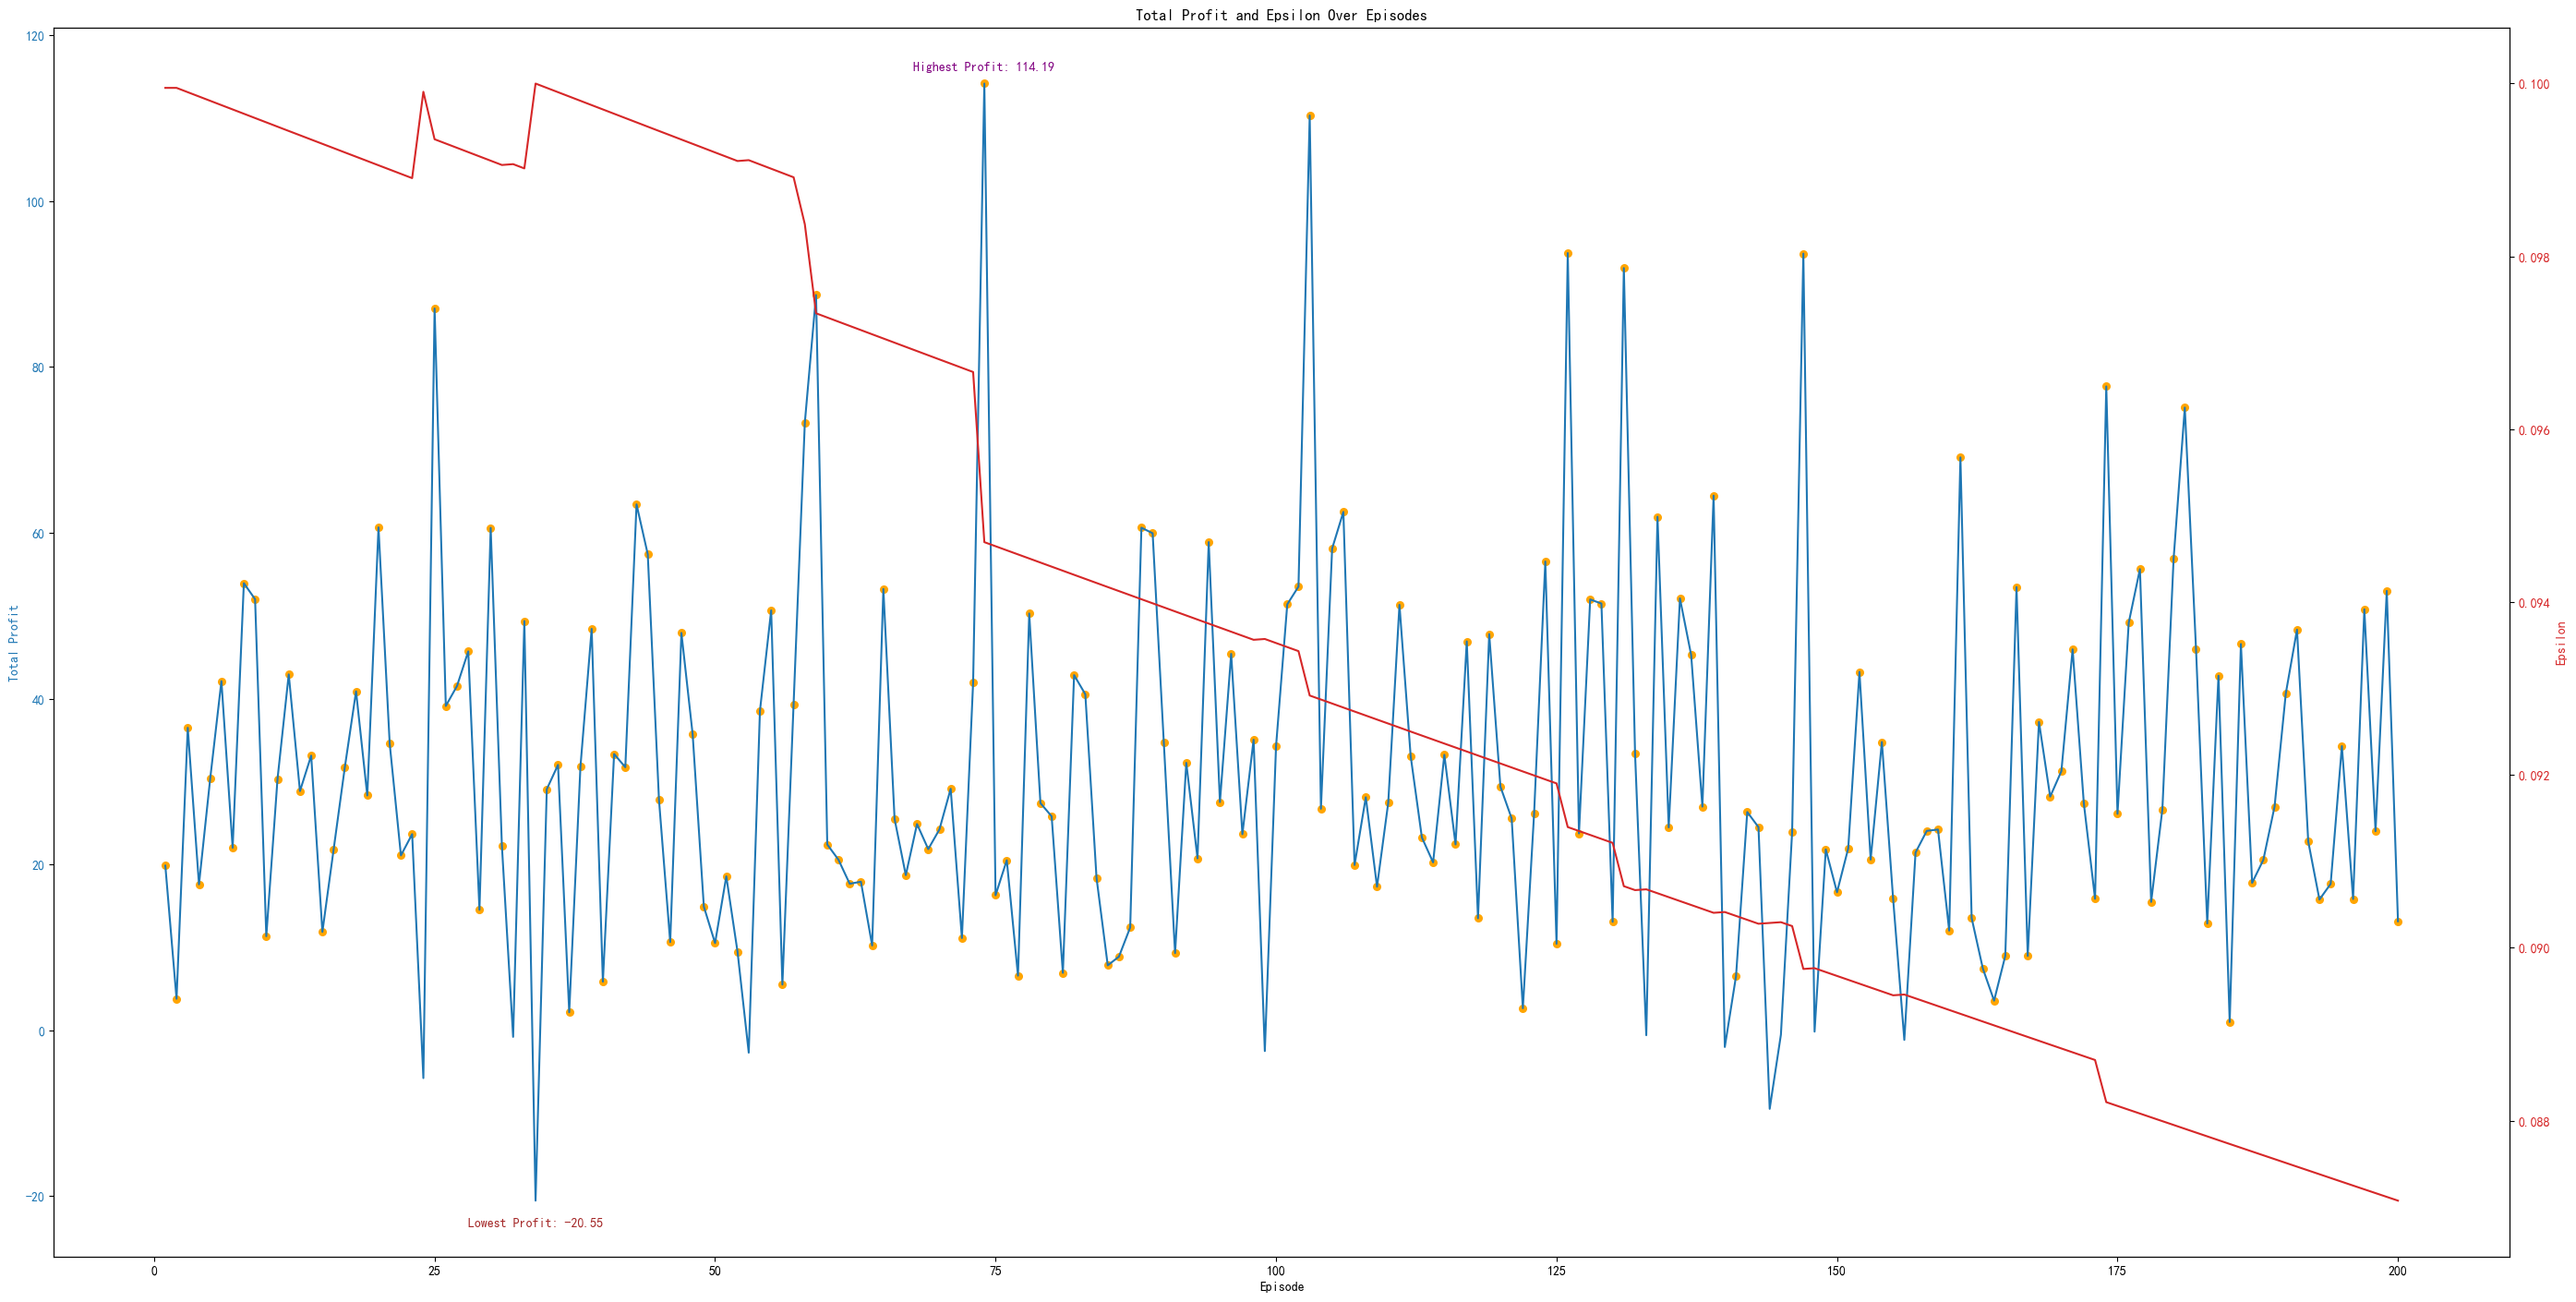

In [26]:
# 输出最佳操作日志到csv
operation_df.to_csv('best_operations.csv', index=False)

import csv
import matplotlib.pyplot as plt

# 定义读取 CSV 的函数
def read_csv(file_path):
    episodes = []
    profits = []
    epsilons = []
    
    with open(file_path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            episodes.append(int(row[0]))
            profits.append(float(row[1]))
            epsilons.append(float(row[2]))
    
    return episodes, profits, epsilons

# 创建图形和子图
fig, ax1 = plt.subplots(figsize=(28, 14))

# 设置初始的Y轴标签
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Profit', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 创建第二个Y轴
ax2 = ax1.twinx()
ax2.set_ylabel('Epsilon', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 读取全部数据
episodes, profits, epsilons = read_csv("training_results.csv")

# 找出全体数据中的最大和最小收益
max_profit = max(profits)
min_profit = min(profits)

# 绘制最近2000条数据
if len(episodes) > 2000:
    recent_episodes = episodes[-2000:]
    recent_profits = profits[-2000:]
    recent_epsilons = epsilons[-2000:]
else:
    recent_episodes = episodes
    recent_profits = profits
    recent_epsilons = epsilons

# 绘制图形
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Profit', color='tab:blue')
ax1.plot(recent_episodes, recent_profits, color='tab:blue', label='Total Profit')

# 标记出所有最近收益率为正的点
for i in range(len(recent_profits)):
    if recent_profits[i] > 0:
        ax1.scatter(recent_episodes[i], recent_profits[i], color='orange', s=30)

# 标记全体数据中的最高收益
max_index = profits.index(max_profit)
ax1.annotate(f'Highest Profit: {max_profit:.2f}', 
            (episodes[max_index], max_profit),
            textcoords="offset points", 
            xytext=(0,10), 
            ha='center', fontsize=10, color='Purple', fontweight='bold')

# 标记全体数据中的最低收益
min_index = profits.index(min_profit)
ax1.annotate(f'Lowest Profit: {min_profit:.2f}', 
            (episodes[min_index], min_profit),
            textcoords="offset points", 
            xytext=(0,-20), 
            ha='center', fontsize=10, color='Brown', fontweight='bold')

ax1.tick_params(axis='y', labelcolor='tab:blue')

# 绘制 epsilon 曲线
ax2.set_ylabel('Epsilon', color='tab:red')
ax2.plot(recent_episodes, recent_epsilons, color='tab:red', label='Epsilon')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  
plt.title('Total Profit and Epsilon Over Episodes')
plt.show()